# Predicting Newsletter Subscription from Player Age in a Minecraft Research Server


# Introduction:

In this course, we complete a full data science project from beginning to end and communicate the entire workflow in a single Jupyter Notebook. The notebook combines code cells and Markdown cells: code cells are used to download the data, wrangle and clean it in a reproducible way, perform exploratory analysis and fit predictive models; Markdown cells narrate each step, explain the question being asked, motivate our methodological choices, and summarize the conclusions. By the end of the project, the notebook functions both as an analysis script and as a written report that another reader can run and understand from top to bottom.

The data for this project come from a research group in Computer Science at the University of British Columbia that operates a custom Minecraft server. Players can join this server, explore a shared world, and interact with various in-game tasks. As part of a research study on human behaviour in video games, the group collects information about who joins the server and how they play. Running such a study is logistically challenging: the team must recruit enough players to obtain useful data, but they must also ensure that they have enough technical resources—such as server capacity and software licenses—to support those players. Understanding which kinds of players are most engaged with the project is therefore practically important.

One simple signal of engagement is whether a player subscribes to a game-related email newsletter. Players who subscribe are likely to be interested in future updates and may be more inclined to return to the server, participate in follow-up experiments, or respond to surveys. From the research group’s perspective, being able to predict which players are likely to subscribe could help them target recruitment efforts (for example, by tailoring messages to specific age groups) and plan resources more efficiently.

In this report we focus on the following predictive question:

> **Can we predict whether a player subscribes to the newsletter based on their age?**

To address this question, we use the `players.csv` data set provided by the research team. This file is a player-level summary: it contains one row for each unique player who joined the Minecraft server. In total, there are 196 players and 7 variables:

- `experience`: the player’s self-reported Minecraft experience level (e.g., “beginner”, “intermediate”, “expert”);
- `hashedEmail`: an anonymized identifier derived from the player’s email address, used to link records without revealing personal information;
- `name`: the player’s in-game name;
- `gender`: the player’s self-reported gender;
- `played_hours`: the total number of hours the player has spent on the server;
- `Age`: the player’s age in years (numeric);
- `subscribe`: a logical indicator of whether the player subscribed to the newsletter (`TRUE` for subscribed, `FALSE` for not subscribed).

For our main analysis we focus on `Age` as the explanatory variable and `subscribe` as the binary response variable. We begin by cleaning the `players.csv` data: we remove players with missing age or subscription information and convert `subscribe` into a factor with levels *No* and *Yes* for ease of visualization and modelling. This yields a cleaned data set of 194 players. We then compute summary statistics and create exploratory visualizations to understand how newsletter subscription rates vary across age groups. Finally, guided by the methods introduced in this class, we fit and evaluate a K-nearest neighbours classification model that uses age to predict whether a player subscribes to the newsletter, and we discuss what the results suggest about the role of age in player engagement on the Minecraft server.


# Methods: 

describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.


# Code:

In [13]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

Loading data into R by using link from github so it is reproducible:

In [32]:
players <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [33]:
players_age <- players |> 
  filter(!is.na(Age),
         !is.na(subscribe)) |>
  mutate(
    subscribe = factor(subscribe,
                       levels = c(FALSE, TRUE),
                       labels = c("No", "Yes"))
  )


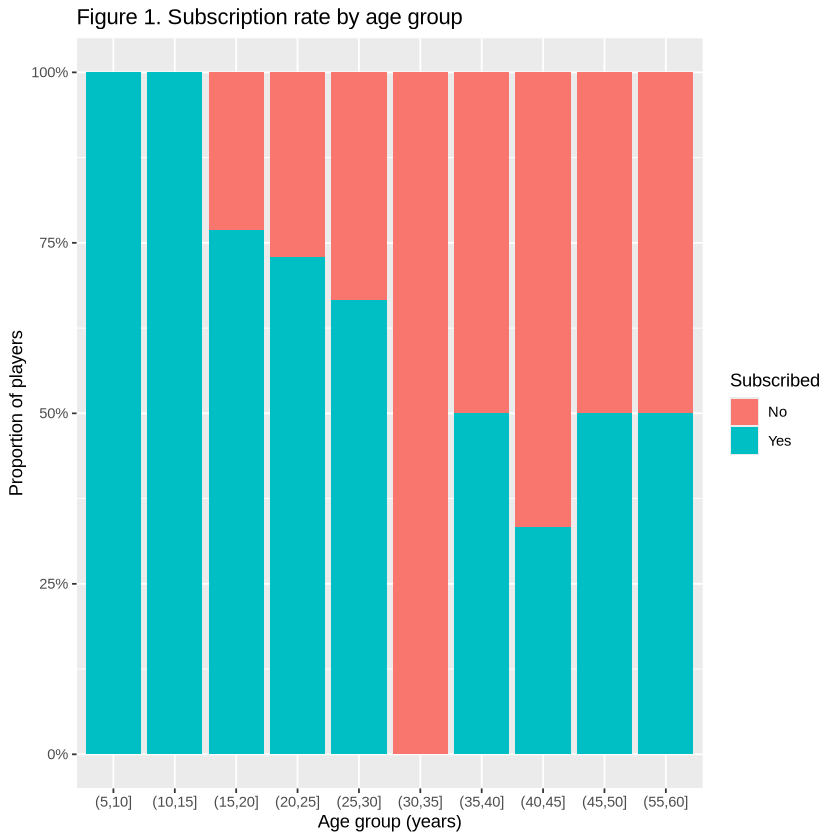

In [34]:
p_age <- players_age |>
  mutate(age_group = cut(Age,
                         breaks = seq(5, 60, by = 5),
                         right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = "Figure 1. Subscription rate by age group",
    x = "Age group (years)",
    y = "Proportion of players",
    fill = "Subscribed"
  )

p_age

In [35]:
set.seed(123)

players_split <- initial_split(players_age, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

subscribe_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_normalize(all_predictors())

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(knn_spec)

grid_k <- tibble(neighbors = seq(1, 51, by = 2))

set.seed(123)
knn_results <- players_wflow |>
  tune_grid(resamples = players_vfold,
            grid      = grid_k) |>
  collect_metrics()


In [36]:
best_k <- knn_results |>
  filter(.metric == "accuracy") |>
  slice_max(mean, n = 1) |>
  pull(neighbors)

best_k

[1] 31

In [37]:
final_knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = best_k
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

final_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(final_knn_spec)

final_fit <- final_wflow |>
  fit(data = players_train)

test_pred <- predict(final_fit, players_test, type = "prob") |>
  bind_cols(
    predict(final_fit, players_test),
    players_test |> select(subscribe, Age)
  )

head(test_pred)


.pred_No,.pred_Yes,.pred_class,subscribe,Age
<dbl>,<dbl>,<fct>,<fct>,<dbl>
0.3548387,0.6451613,Yes,Yes,17
0.3548387,0.6451613,Yes,No,17
0.1935484,0.8064516,Yes,No,21
0.3548387,0.6451613,Yes,Yes,17
0.4516129,0.5483871,Yes,Yes,58
0.5161290,0.4838710,No,No,18


In [38]:
test_metrics <- metrics(test_pred,
                        truth   = subscribe,
                        estimate = .pred_class) |>
  filter(.metric == "accuracy")
test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75



# Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to


# References

You may include references if necessary, as long as they all have a consistent citation style.